# Data Analysis Notebook
### Project Initialization
This notebook serves as the foundation for a data analysis project. It is currently in its early stage, focusing on setting up the environment, exploring the dataset, and performing initial processing steps.

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import emoji
from langdetect import detect, DetectorFactory
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import unicodedata
import spacy

## 2. Load and Explore the Dataset
We start by loading the dataset and exploring its basic structure to understand the available variables and potential data quality issues.

In [2]:
# Load dataset
df = pd.read_excel("./youtube_results_tariffs_filled.xlsx", sheet_name="Sheet1")

# Display basic info
df.info()
df.head()

# we created a working Copy of the Dataset

df_clean = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6227 entries, 0 to 6226
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   videoId      6227 non-null   object
 1   title        6227 non-null   object
 2   description  6139 non-null   object
 3   commentId    6227 non-null   object
 4   comment      6226 non-null   object
 5   likes        6227 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 292.0+ KB


In [3]:
df.head()

,videoId,title,description,commentId,comment,likes
0,FUkkYuNAMcQ,Trump Says That As Of November 1 China Will Be...,"Speaking to reporters in the Oval Office, Pres...",UgxHRUqJokW4sp4nght4AaABAg,China does not give a shit about US markets......,0
1,FUkkYuNAMcQ,Trump Says That As Of November 1 China Will Be...,"Speaking to reporters in the Oval Office, Pres...",UgwcDaeymwDa42bSL5l4AaABAg,Trump will destroy American economy. Xi doesn’...,1
2,FUkkYuNAMcQ,Trump Says That As Of November 1 China Will Be...,"Speaking to reporters in the Oval Office, Pres...",UgwafOA7XzpX_VnWgkR4AaABAg,Trump is killing my business and employees rig...,0
3,FUkkYuNAMcQ,Trump Says That As Of November 1 China Will Be...,"Speaking to reporters in the Oval Office, Pres...",UgxRfEAE81sAwvKYm3p4AaABAg,The way clown talking is brutal 😂,0
4,FUkkYuNAMcQ,Trump Says That As Of November 1 China Will Be...,"Speaking to reporters in the Oval Office, Pres...",UgxcA-sOeFVYBNNFCzR4AaABAg,Why is Mr Trump continuing to say that the cou...,0


## 3. Data Cleaning and Preprocessing

### 3.1 Language Detection and Filtering
Firstly, it's important to detect and filter the comments that are only written in English, since the analysis will be based only on English words

In [4]:
def detect_language(text):
    """Detect the language of the given text using langdetect."""
    if pd.isna(text):
        return ""
    text = str(text)
    try:
        return detect(text)
    except:
        return "unknown"

df_clean['lang'] = df_clean['comment'].apply(detect_language)

# Keep only English comments
df_clean = df_clean[df_clean['lang'] == 'en'].copy()


### 3.2 Text Cleaning Function
We create a first coarse cleaning function in order to remove HTML tags, URLs, symbols, and converting emojis to words.

In [5]:
def clean_text(text):
    # Gestisce NaN, numeri, o altri tipi non stringa
    if not isinstance(text, str):
        text = ""  # oppure str(text) se vuoi mantenere numeri

    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))

    text = text.replace("_", " ")


    # Remove HTML tags, URLs, HTML entities, and non-text symbols
    text = re.sub(r'<.*?>', ' ', text)             # HTML tags
    text = re.sub(r'http\S+', ' ', text)          # URLs
    text = re.sub(r'&#\d+;', ' ', text)           # HTML numeric entities
    text = re.sub(r'&\w+;', ' ', text)            # HTML text entities
    text = re.sub(r'[^\w\s.,!?\'"]', ' ', text)   # Non-text symbols
    text = re.sub(r'\s+', ' ', text)              # Multiple spaces

    return text.strip()


# Apply text cleaning
df_clean['comment'] = df_clean['comment'].apply(clean_text)
df_clean['description'] = df_clean['description'].apply(clean_text)

# Remove Duplicates and Empty Comments

df_clean = df_clean.drop_duplicates(subset='comment')
df_clean = df_clean[df_clean['comment'].str.strip() != ""]


In [7]:
# cheecking conversion of emojis
df_clean.loc[3, 'comment']

'The way clown talking is brutal face with tears of joy'

### Diagnostic Visualization
We perform a quick check of the dataset to identify the most frequent words, helping to spot potentially redundant or noisy terms that should be addressed in the next cleaning phase

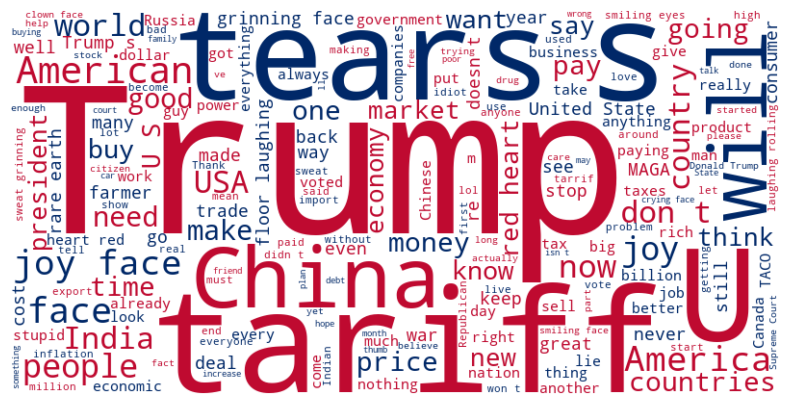

In [9]:
import random

# Join all comments into one string
all_comments = " ".join(df_clean['comment'].tolist())

# Define USA flag color function
def usa_flag_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(["rgb(191, 10, 48)", "rgb(0, 40, 104)"])  # Old Glory Red and Blue

# Generate and recolor the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(all_comments)

wordcloud = wordcloud.recolor(color_func=usa_flag_color_func)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 3.3 Stopwords removal
Using the library "Stop Words" we are now trying to remove all the words that we can consider useless in a sentimental analysis. We also wanted to remove others words that are quite a lot predominant, which are only related to the topic we're discussing, that can be rendundant, and so noisy

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
stop_words = set(stopwords.words('english'))

# Add domain-specific and emoji-based custom stopwords
custom_stopwords = {
    'trump', 'donald', 'tariff', 'tariffs', 'china', 'american', 'america', 'americans',
    'u', 'us', 'usa', 'president', 'country', 'countries',
    'indian', 'india'
}

# Combine standard and custom stopwords
all_stopwords = stop_words.union(custom_stopwords)

def remove_stopwords(text):
    """Remove standard and custom stopwords from the given text."""
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    return " ".join([word for word in text.split() if word not in all_stopwords])

df_clean['comment_clean'] = df_clean['comment'].apply(remove_stopwords)


df_clean.head()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_comments = " ".join(df_clean['comment_clean'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
df_clean

### 3.4 Unicode normalization

- Unicode Normalization: Converts characters to a consistent Unicode format (NFKD), which separates base characters from their diacritics (e.g., é becomes e + ́). This ensures that visually identical characters are treated the same in downstream tasks.
- Accent Removal (Optional): If remove_accents=True, the function strips away accents and special characters by encoding the text to ASCII and ignoring non-ASCII symbols. 



In [10]:

def normalize(text, remove_accents=True):
    """
    Normalize Unicode characters and convert text to lowercase.
    
    Parameters:
        text (str): Input string to clean.
        remove_accents (bool): If True, strip accents and special characters.
    
    Returns:
        str: Cleaned and normalized text.
    """
    # Normalize to NFKD form (decomposed characters)
    normalized = unicodedata.normalize('NFKD', text)
    
    # Optionally remove accents by encoding to ASCII
    if remove_accents:
        normalized = normalized.encode('ascii', 'ignore').decode('utf-8')
    
    return normalized

In [11]:
df_clean['comment_norm'] = df_clean['comment'].apply(normalize)

In [12]:
df_clean['comment_norm'].head()

0    China does not give a shit about US markets......
1    Trump will destroy American economy. Xi doesn ...
2    Trump is killing my business and employees rig...
3    The way clown talking is brutal face with tear...
4    Why is Mr Trump continuing to say that the cou...
Name: comment_norm, dtype: object

In [13]:
df_clean['comment'].head()

0    China does not give a shit about US markets......
1    Trump will destroy American economy. Xi doesn ...
2    Trump is killing my business and employees rig...
3    The way clown talking is brutal face with tear...
4    Why is Mr Trump continuing to say that the cou...
Name: comment, dtype: object

### 3.5 Lemmatization

Lemmatization helps reduce words to their base or dictionary form — which improves clustering by grouping similar words together (e.g., “running”, “ran”, and “runs” all become “run”).


In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\valem\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
sid = SentimentIntensityAnalyzer()


In [17]:

def lemmatization(text):
    doc = nlp(text)

    cleaned_tokens = []
    negate = False

    for token in doc:
        # Preserve named entities
        if token.ent_type_ in ["GPE", "ORG", "PERSON"]:
            cleaned_tokens.append(token.text)
            continue

        # Handle negation
        if token.dep_ == "neg" or token.lower_ in ["not", "n't", "never", "no"]:
            cleaned_tokens.append("not")
            negate = True
            continue

        # Replace profanity with neutral sentiment-preserving terms
        if token.lower_ in ["shit", "fuck", "damn"]:
            cleaned_tokens.append("care" if negate else "bother")
            negate = False
            continue

        # Preserve sentiment-bearing words
        if sid.polarity_scores(token.text)['compound'] != 0:
            cleaned_tokens.append(token.lemma_)
            continue

        # Keep important nouns and verbs
        if token.pos_ in ["NOUN", "VERB", "ADJ"] and not token.is_stop:
            cleaned_tokens.append(token.lemma_)

    # Reconstruct cleaned sentence
    cleaned_sentence = " ".join(cleaned_tokens)
    cleaned_sentence = re.sub(r"\s+", " ", cleaned_sentence).strip()
    return cleaned_sentence

In [18]:
df_clean['comment_lemm'] = df_clean['comment_norm'].apply(lemmatization)

In [ ]:

# Load English language model
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    """
    Lemmatizes input text using spaCy.
    
    Returns the text with words replaced by their lemma forms.
    """
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct])

In [ ]:
df_clean['comment_lemm'] = df_clean['comment_norm'].apply(lemmatize_text)

In [19]:
df_clean[['comment','comment_lemm']].head()

,comment,comment_lemm
0,China does not give a shit about US markets......,China not care US market market big Trump worr...
1,Trump will destroy American economy. Xi doesn ...,Trump destroy american economy Xi doesn t watc...
2,Trump is killing my business and employees rig...,Trump kill business employee please figure rea...
3,The way clown talking is brutal face with tear...,way clown talk brutal face tear joy
4,Why is Mr Trump continuing to say that the cou...,Trump continue country s slap pay Don tax grea...


In [25]:
df_clean.loc[0,'comment']

'China does not give a shit about US markets..... Whose market is bigger? Trump should worry about his own approval ratings and stock prices, and how to feed his own army who is now queueing up for free canned foods'

In [24]:
df_clean.loc[0,'comment_lemm']

'China not care US market market big Trump worry approval rating stock price feed army queue free can food'

In [21]:
df_clean.loc[3,'comment']

'The way clown talking is brutal face with tears of joy'

In [20]:
df_clean.loc[3,'comment_lemm']

'way clown talk brutal face tear joy'

In [ ]:
df_clean.drop(columns=['comment_norm', 'lang'])

In [26]:
df_clean.rename(columns={'comment_lemm': 'comment_clean'}, inplace=True)

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5450 entries, 0 to 6226
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   videoId        5450 non-null   object
 1   title          5450 non-null   object
 2   description    5450 non-null   object
 3   commentId      5450 non-null   object
 4   comment        5450 non-null   object
 5   likes          5450 non-null   int64 
 6   comment_clean  5450 non-null   object
dtypes: int64(1), object(6)
memory usage: 469.7+ KB


In [28]:
df_clean.to_excel("youtube_results_tariffs_cleaned.xlsx", index=False)